In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# **Tạo bộ dữ liệu để huấn luyện**

In [ ]:
PATH_TRAIN = '/content/drive/MyDrive/thuan_truyenthong_vn/train'
PATH_VALIDATE = '/content/drive/MyDrive/thuan_truyenthong_vn/validate'
PATH_TEST = '/content/drive/MyDrive/thuan_truyenthong_vn/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_dataset = image_dataset_from_directory(PATH_TRAIN,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validate_dataset = image_dataset_from_directory(PATH_VALIDATE,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(PATH_TEST,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 3959 files belonging to 17 classes.
Found 1068 files belonging to 17 classes.
Found 1264 files belonging to 17 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['Bánh bèo', 'Bánh bông lan', 'Bánh canh hẹ', 'Bánh chưng', 'Bánh khọt', 'Bánh mì', 'Bánh xèo', 'Bánh đa cua', 'Bún bò', 'Canh khổ qua', 'Cháo', 'Cơm cháy', 'Cơm tấm', 'Gỏi cuốn', 'Phở', 'Thịt kho Tàu', 'Xôi']


In [ ]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validate_batches = tf.data.experimental.cardinality(validate_dataset)
test_batches = tf.data.experimental.cardinality(test_dataset)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
ưprint(np.min(first_image), np.max(first_image))

0.0 0.9894422


In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(17)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Let's take a look to see how many layers are in the base model
model.trainable = True
print("Number of layers in the base model: ", len(model.layers))


Number of layers in the base model:  6


In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                8721      
Total params: 20,033,105
Trainable params: 20,033,105
Non-trainable params: 0
_______________________________________________

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True)

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping],
)

Epoch 1/100
124/124 [==============================] - 67s 542ms/step - loss: 2.8302 - accuracy: 0.0677 - val_loss: 2.8296 - val_accuracy: 0.0599
Epoch 2/100
124/124 [==============================] - 67s 544ms/step - loss: 2.8277 - accuracy: 0.0730 - val_loss: 2.8397 - val_accuracy: 0.0599
Epoch 3/100
124/124 [==============================] - 67s 543ms/step - loss: 2.8222 - accuracy: 0.0692 - val_loss: 2.8140 - val_accuracy: 0.0646
Epoch 4/100
124/124 [==============================] - 67s 540ms/step - loss: 2.7933 - accuracy: 0.0763 - val_loss: 2.7647 - val_accuracy: 0.0646
Epoch 5/100
124/124 [==============================] - 67s 543ms/step - loss: 2.7006 - accuracy: 0.0854 - val_loss: 2.6988 - val_accuracy: 0.1170
Epoch 6/100
124/124 [==============================] - 68s 548ms/step - loss: 2.6187 - accuracy: 0.1296 - val_loss: 2.6000 - val_accuracy: 0.1526
Epoch 7/100
124/124 [==============================] - 68s 545ms/step - loss: 2.4565 - accuracy: 0.1829 - val_loss: 2.4464 -

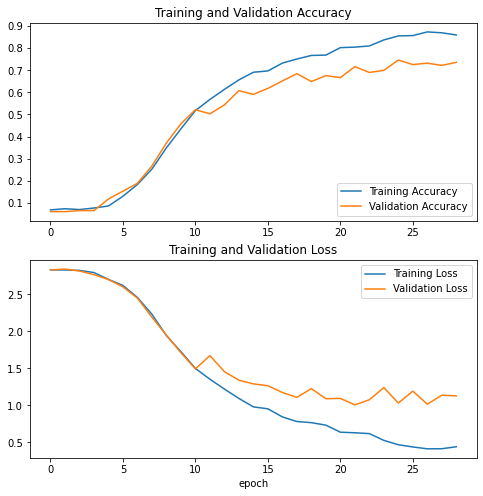

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


(32, 224, 224, 3)
Predictions:
 ['Bánh\nđa\ncua', 'Canh\nkhổ\nqua', 'Bánh\nmì', 'Gỏi\ncuốn', 'Canh\nkhổ\nqua', 'Bánh\nbông\nlan', 'Canh\nkhổ\nqua', 'Cơm\ncháy', 'Bánh\nkhọt', 'Bánh\nchưng', 'Thịt\nkho\nTàu', 'Bánh\nkhọt', 'Cơm\ncháy', 'Thịt\nkho\nTàu', 'Xôi', 'Bánh\nbèo', 'Bánh\nbèo', 'Xôi', 'Bánh\nbèo', 'Bánh\nkhọt', 'Bánh\nbèo', 'Bánh\nkhọt', 'Bánh\nbông\nlan', 'Cơm\ncháy', 'Phở', 'Xôi', 'Bánh\nmì', 'Bánh\nbông\nlan', 'Cháo', 'Cơm\ncháy', 'Bánh\nkhọt', 'Bánh\nchưng', 'Bún\nbò', 'Bánh\nkhọt', 'Phở', 'Gỏi\ncuốn', 'Bánh\nbèo', 'Bánh\nmì', 'Bún\nbò', 'Canh\nkhổ\nqua', 'Bánh\nđa\ncua', 'Thịt\nkho\nTàu', 'Bún\nbò', 'Xôi', 'Bánh\nbông\nlan', 'Bánh\nchưng', 'Cơm\ncháy', 'Bánh\nchưng', 'Bánh\ncanh\nhẹ', 'Cháo', 'Canh\nkhổ\nqua', 'Cơm\ntấm', 'Bánh\nxèo', 'Cơm\ncháy', 'Xôi', 'Cơm\ncháy', 'Canh\nkhổ\nqua', 'Bánh\nchưng', 'Xôi', 'Bánh\nxèo', 'Canh\nkhổ\nqua', 'Cháo', 'Bánh\nbèo', 

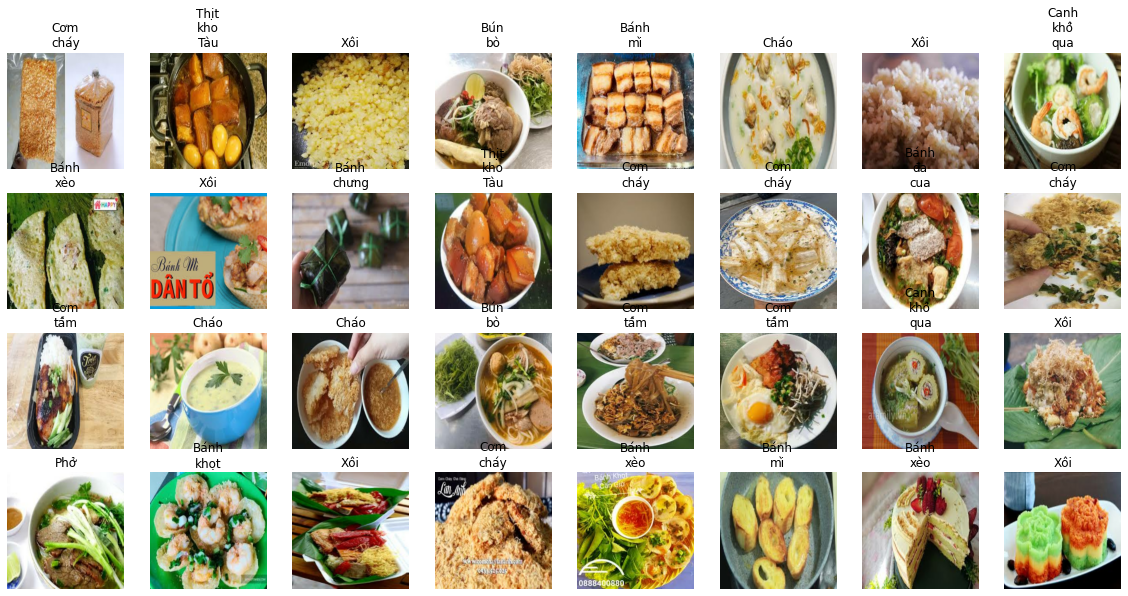

In [ ]:
#Retrieve a batch of images from the test set
predictions = []
label_batch = []
scores = []
class_names = [ label.replace(' ', '\n') for label in class_names ]
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(test_batches):
  for i in range(len(labels)):
    ax = plt.subplot(6, 8, i + 1)
    img = images[i].numpy().astype("uint8")
    img = tf.expand_dims(img, 0)
    prediction = model.predict(img)
    score = tf.nn.softmax(prediction[0])
    predictions.append(class_names[np.argmax(score)])
    label_batch.append(class_names[labels[i]])
    scores.append(100 * np.max(score))
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")

print(image_batch.shape)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

In [ ]:
pre_recall = []
label = ''
for i in range(len(predictions)):
  if predictions[i] == label_batch[i]:
    label = "true"
  else:
    label = "false"
  pre_recall.append(label)
ground_truth = 0
map = 0
for i, label in enumerate(pre_recall):
  if label == "true":
    ground_truth = ground_truth + 1
    map = map + ground_truth / (i + 1)
print("mAP: ",map / ground_truth)

mAP:  0.7008319966543551


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

recall = recall_score(label_batch, predictions, average='macro')
precision = precision_score(label_batch, predictions, average='macro')
f1 = f1_score(label_batch, predictions, average='macro')


print("f1 {}".format(f1))
print("precision {}".format(precision))
print("recall {}".format(recall))

f1 0.7192912813454105
precision 0.7268670974890741
recall 0.7233006276019667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


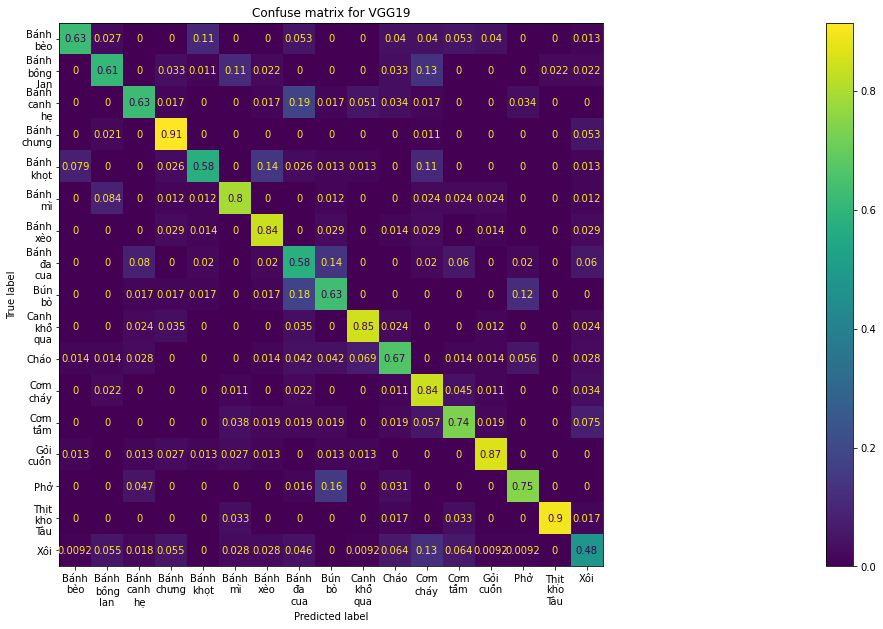

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from textwrap import wrap


cm = confusion_matrix(label_batch, predictions, labels=class_names, normalize='true')

plt.figure(figsize=(80, 10))
plt.title('Confuse matrix for VGG19')
ax = plt.subplot(1, 1, 1)

cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax)

In [ ]:
model.save("my_model_vgg19")

INFO:tensorflow:Assets written to: my_model_vgg19/assets
